In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [2]:
def read_file(path):
    with open(path) as f:
        data = f.readlines()
    return data


def get_start_end(data):
    for i, d in enumerate(data):
        if 'classes' in d:
            start = i
        if 'Score Average' in d:
            end = i
            return start, end
        
        
def get_pixel_accuracy(data):
    for i, d in enumerate(data):
        if "pixel accuracy" in d:
            return float(data[i+1].strip())
            
        
def get_miou(dataset):
    result = np.zeros(20)
    start, end = get_start_end(dataset)
    i = 0
    for data in dataset[start:end+1]:
        data = data.strip().split(':')
        if len(data) > 1:
            miou = float(data[1].split()[0])
            result[i] = miou
            i += 1

    return result.reshape((1, 20))


def get_classnames(dataset):
    res = []
    start, end = get_start_end(dataset)
    for data in dataset[start:end+1]:
        data = data.strip().split(':')
        if len(data) > 1:
            res.append(data[0].strip())
    return res


def get_mious(model_name, drops,  knn=False, linear=False):
    if knn:
        if '7' in model_name:
            name = model_name.split('_')[0]
            path_0 = f'../openseg.pytorch/cs4pc_{name}_256_val_knn_72_train_30_val_layer_7.txt'
            path_part = f'../openseg.pytorch/{model_name}_val_cs_patches_256_knn_train_72_val_30_first_'
        else:
            path_0 = f'../openseg.pytorch/cs4pc_{model_name}_256_val_knn_72_train_30_val_layer_12.txt'
            path_part = f'../openseg.pytorch/{model_name}_val_cs_patches_256_knn_train_72_val_30_first_'
    if linear:
        if '7' in model_name:
            path_0 = f'../openseg.pytorch/{model_name}_val_cs_patches_256_linear_layer.txt'
        else:
            path_0 = f'../openseg.pytorch/{model_name}_val_cs_patches_256_linear_layer_12.txt'    
        path_part = f'../openseg.pytorch/{model_name}_val_cs_patches_256_linear_first_'
        
    mious = []
    for drop in drops:
        if drop == 0:
            miou = get_miou(read_file(path_0))
            mious.append(miou)
        else:
            path = path_part+f'{drop}.txt'
            miou = get_miou(read_file(path))
            mious.append(miou)

    mious = np.concatenate(mious, axis=0)
    return mious
        

In [73]:
class_names = get_classnames(read_file('../openseg.pytorch/mae_val_cs_patches_256_linear_layer_12.txt'))

In [74]:
knn_results = {}

In [75]:
linear_results = {}

In [76]:
models = ['sup_vit', 'dino', 'dinov2', 'mae', 'simmim', 'simmim_l7']
model_title = dict(zip(models, ['Supervised ViT', 'DINO', 'DINOv2', 'MAE', 'SimMIM', 'SimMIM (layer 7)']))

In [77]:
drops = np.array([0, 10, 20, 30, 40, 50, 100, 200, 400, 600, 750])

for model in models:
    knn_results[model] = get_mious(model, drops, knn=True)
    linear_results[model] = get_mious(model, drops, linear=True)

In [78]:
knn_results[model].shape

(11, 20)

In [79]:
knn_results['mae'][:, -1], linear_results['mae'][:, -1]

(array([0.058096, 0.169994, 0.198159, 0.218504, 0.227643, 0.253179,
        0.277036, 0.294701, 0.288511, 0.263043, 0.026548]),
 array([0.375182, 0.373585, 0.373925, 0.371039, 0.376631, 0.369163,
        0.369858, 0.364433, 0.328893, 0.243497, 0.060181]))

In [80]:
!pwd

/home/hkhachatrian/mae/jupyter_notebooks


In [81]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


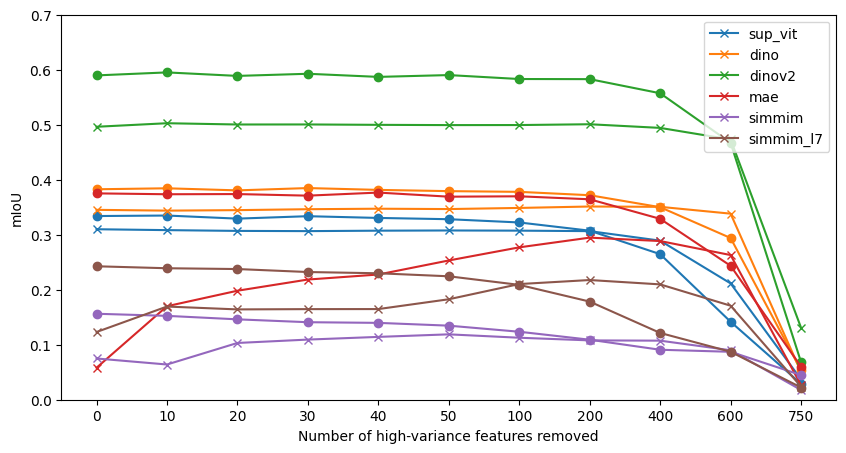

In [82]:
plt.figure(figsize=(10, 5))
for mi, model in enumerate(models):
    x = range(len(drops))
    plt.plot(x, knn_results[model][:,-1], marker='x', color=f'C{mi}', label=model);
    plt.plot(x, linear_results[model][:,-1], marker='o', color=f'C{mi}');
plt.ylabel("mIoU")
plt.xlabel("Number of high-variance features removed")
# plt.xscale('log')
# plt.xlim(10, 750)
plt.legend()
plt.ylim(0, 0.7)
plt.xticks(x, drops);

In [15]:
!mkdir ./images/variance


In [136]:
fs = 14

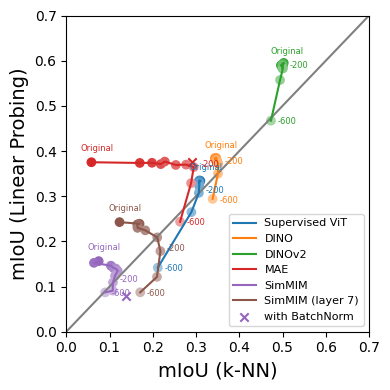

In [148]:
plt.figure(figsize=(4, 4))
plt.plot([0, 0.7], [0, 0.7], color='grey')
for mi, model in enumerate(models):
    x = range(len(drops))
    cmap = mcolors.LinearSegmentedColormap.from_list("", [f"C{mi}", "white"])
    plt.plot(knn_results[model][:-1,-1], linear_results[model][:-1,-1], marker=None, color=f'C{mi}', label=model_title[model]);
    plt.scatter(knn_results[model][:-1,-1], linear_results[model][:-1,-1], 
                c=1 + np.arange(len(drops)-1), vmax=6 + len(drops), cmap=cmap, marker='o');
    plt.text(knn_results[model][0,-1]-0.025, linear_results[model][0,-1]+0.025, "Original", color=f'C{mi}', fontsize=6)
    plt.text(knn_results[model][-4,-1]+0.015, linear_results[model][-4,-1]+0.0, "-200", color=f'C{mi}', fontsize=6)
    plt.text(knn_results[model][-2,-1]+0.015, linear_results[model][-2,-1]-0.008, "-600", color=f'C{mi}', fontsize=6)
    
plt.scatter([0.139], [0.078], color='C4', marker='x', label='with BatchNorm')
plt.scatter([0.291], [0.375], color='C3', marker='x')

plt.xlabel("mIoU (k-NN)", fontsize=fs)
plt.ylabel("mIoU (Linear Probing)", fontsize=fs)
# plt.xscale('log')
# plt.xlim(10, 750)
plt.legend(loc='lower right', fontsize=8)
plt.xlim(0, 0.7)
plt.ylim(0, 0.7)
plt.tight_layout()

plt.savefig('./images/variance/cityscapes-nohighvariance.pdf')
# plt.xticks(x, drops);

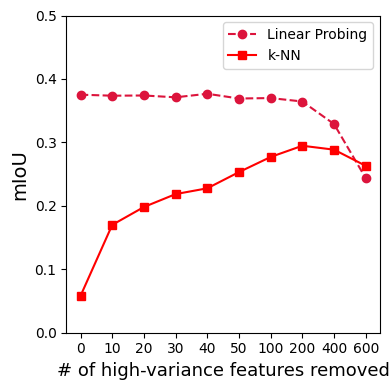

In [154]:
plt.figure(figsize=(4,4))
model='mae'
x = range(len(drops))
plt.plot(x[:-1], linear_results[model][:-1,-1], '--', color='#DC143C', marker='o', label='Linear Probing');
plt.plot(x[:-1], knn_results[model][:-1,-1], color='#FF0000', marker='s', label='k-NN');
plt.ylabel("mIoU", fontsize=fs)
plt.xlabel("# of high-variance features removed", fontsize=fs-1)
# plt.xscale('log')
# plt.xlim(10, 750)
plt.legend()
plt.ylim(0, 0.5)
plt.tight_layout()
plt.xticks(x[:-1], drops[:-1]);

plt.savefig('./images/variance/cityscapes-mae-nohighvariance.pdf')


In [9]:
MODELS = ['dino', 'dinov2', 'mae']
model_title = dict(zip(models, ['Supervised ViT', 'DINO', 'DINOv2', 'MAE', 'SimMIM', 'SimMIM (layer 7)']))

In [10]:
import sys
sys.path.append('/home/hkhachatrian/mae/')
from tqdm.notebook import tqdm
from tracking.utils import get_files

video_embeds = {}
img_size = (224 * 3, 224 * 5)
for t in ['full', 'tile']:
    video_embeds[t] = {}
    for model in tqdm(MODELS):
        video_embeds[t][model] = []
        embeds_dir = f'/mnt/lwll/lwll-coral/hrant/mae_checkpoints/tracking/bdd100k/bbox_embeds_{model}_{img_size[0]}_{img_size[1]}_{t}/track/val/'
        embeds_path_list = sorted(get_files(embeds_dir, '.npy'))
        for embeds_path in embeds_path_list:
            embeds = np.load(embeds_path, allow_pickle=True)
            video_embeds[t][model].append(embeds)

100%|██████████| 3/3 [00:31<00:00, 10.60s/it]


In [11]:
from tqdm.notebook import tqdm

In [4]:
variances = {}
for model in models:
    path = '/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256/layers/'
    if 'l7' in model:
        tmp_embs = np.load(path + f'simmim_cs4pc_256_train_7_embeds.npy')
    else:
        tmp_embs = np.load(path + f'{model}_cs4pc_256_train_12_embeds.npy')
    print(tmp_embs.shape)
    break
    #variances[model] = tmp_embs.var(axis=0)

(451584, 768)


In [101]:
variances.keys()

dict_keys(['sup_vit', 'dino', 'dinov2', 'mae', 'simmim', 'simmim_l7'])

In [102]:
model_title

{'sup_vit': 'Supervised ViT',
 'dino': 'DINO',
 'dinov2': 'DINOv2',
 'mae': 'MAE',
 'simmim': 'SimMIM',
 'simmim_l7': 'SimMIM (layer 7)'}

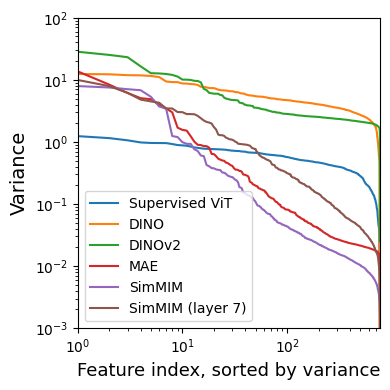

In [153]:
plt.figure(figsize=(4,4))

for mi, model in enumerate(models):
    plt.plot(np.sort(variances[model])[::-1], label=model_title[model], color=f'C{mi}')
plt.yscale('log')
plt.xscale('log')

plt.ylim(0.001, 100)
plt.xlim(1, 768)
plt.legend()
plt.xlabel('Feature index, sorted by variance', fontsize=fs-1)
plt.ylabel('Variance', fontsize=fs)
plt.tight_layout()
plt.savefig('images/variance/feature_variance_comparisons.pdf')
plt.show()

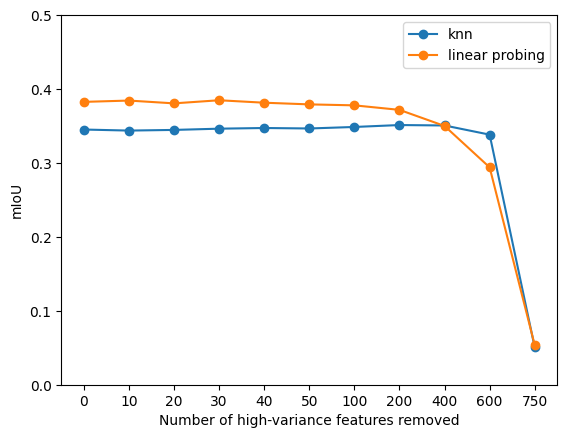

In [14]:
plt.figure()
model='dino'
x = range(len(drops))
plt.plot(x, knn_results[model][:,-1], marker='o', label='knn');
plt.plot(x, linear_results[model][:,-1], marker='o', label='linear probing');
plt.ylabel("mIoU")
plt.xlabel("Number of high-variance features removed")
# plt.xscale('log')
# plt.xlim(10, 750)
plt.legend()
plt.ylim(0, 0.5)
plt.xticks(x, drops);

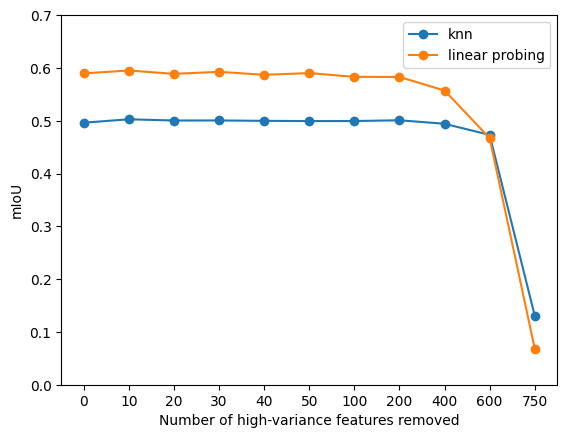

In [16]:
plt.figure()
model='dinov2'
x = range(len(drops))
plt.plot(x, knn_results[model][:,-1], marker='o', label='knn');
plt.plot(x, linear_results[model][:,-1], marker='o', label='linear probing');
plt.ylabel("mIoU")
plt.xlabel("Number of high-variance features removed")
# plt.xscale('log')
# plt.xlim(10, 750)
plt.legend()
plt.ylim(0, 0.7)
plt.xticks(x, drops);

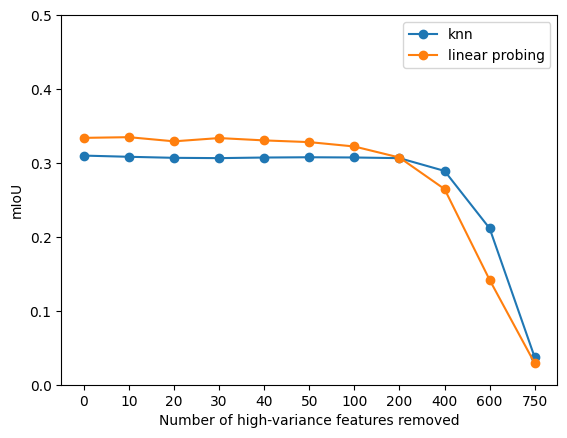

In [17]:
plt.figure()
model='sup_vit'
x = range(len(drops))
plt.plot(x, knn_results[model][:,-1], marker='o', label='knn');
plt.plot(x, linear_results[model][:,-1], marker='o', label='linear probing');
plt.ylabel("mIoU")
plt.xlabel("Number of high-variance features removed")
# plt.xscale('log')
# plt.xlim(10, 750)
plt.legend()
plt.ylim(0, 0.5)
plt.xticks(x, drops);

In [11]:
knn_results[model][-4,-1], linear_results[model][-4,-1]

(0.294701, 0.364433)

In [12]:
knn_results['mae'][:, -1].max()

0.294701

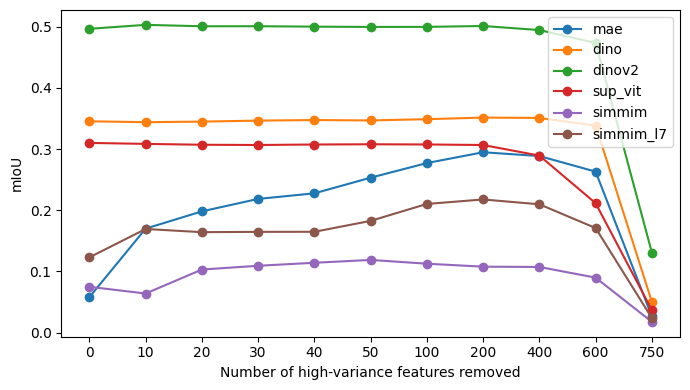

In [13]:
plt.figure(figsize=(7, 4))
x = range(len(drops))
c=-1
plt.plot(x, knn_results['mae'][:,c], marker='o', label='mae');
plt.plot(x, knn_results['dino'][:,c], marker='o', label='dino');
plt.plot(x, knn_results['dinov2'][:,c], marker='o', label='dinov2');
plt.plot(x, knn_results['sup_vit'][:,c], marker='o', label='sup_vit');
plt.plot(x, knn_results['simmim'][:,c], marker='o', label='simmim');
plt.plot(x, knn_results['simmim_l7'][:,c], marker='o', label='simmim_l7');
# plt.plot(x, linear_results[model][:,-1], marker='o', label='linear probing');
plt.ylabel("mIoU")
plt.xlabel("Number of high-variance features removed")
# plt.xscale('log')
# plt.ylim(0, 0.6)
# plt.xlim(10, 750)
plt.legend()
plt.xticks(x, drops);
plt.tight_layout()

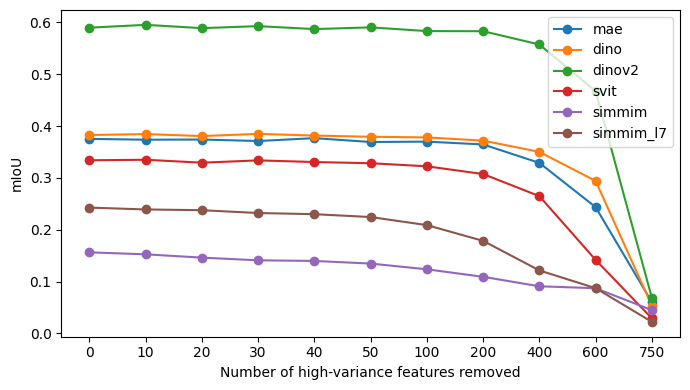

In [88]:
plt.figure(figsize=(7, 4))
x = range(len(drops))
c=-1
plt.plot(x, linear_results['mae'][:,c], marker='o', label='mae');
plt.plot(x, linear_results['dino'][:,c], marker='o', label='dino');
plt.plot(x, linear_results['dinov2'][:,c], marker='o', label='dinov2');
plt.plot(x, linear_results['sup_vit'][:,c], marker='o', label='svit');
plt.plot(x, linear_results['simmim'][:,c], marker='o', label='simmim');
plt.plot(x, linear_results['simmim_l7'][:,c], marker='o', label='simmim_l7');
# plt.plot(x, linear_results[model][:,-1], marker='o', label='linear probing');
plt.ylabel("mIoU")
plt.xlabel("Number of high-variance features removed")
# plt.xscale('log')
# plt.ylim(0, 0.6)
# plt.xlim(10, 750)
plt.legend()
plt.xticks(x, drops);
plt.tight_layout()

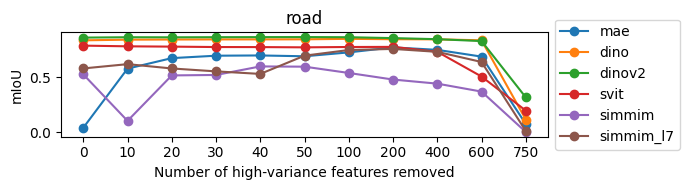

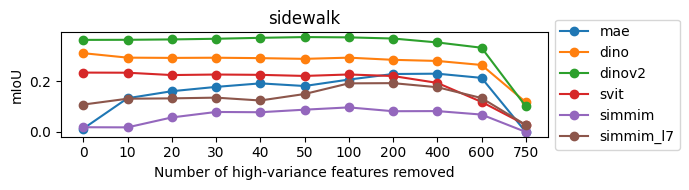

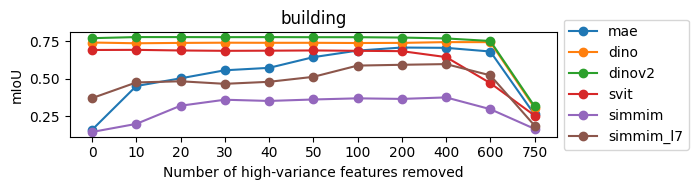

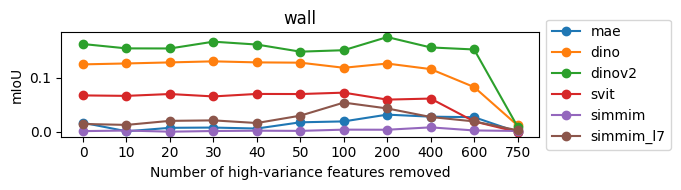

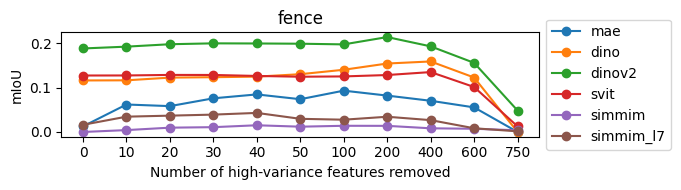

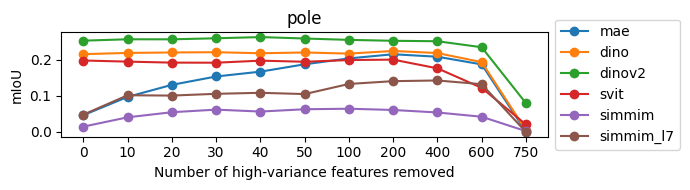

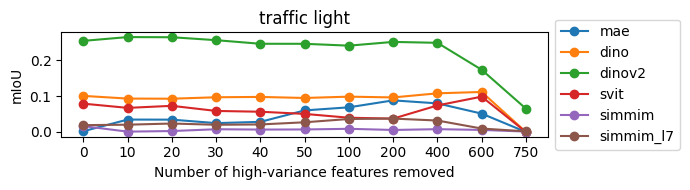

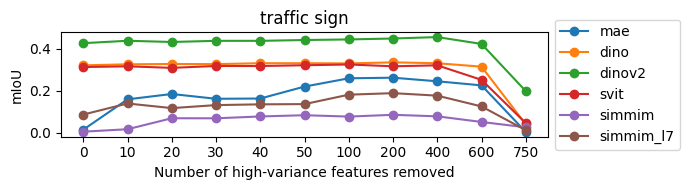

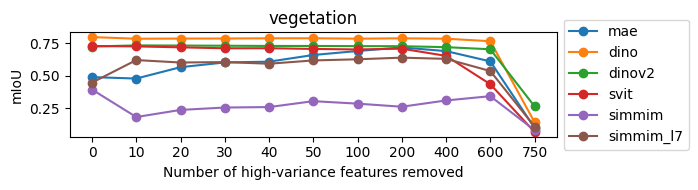

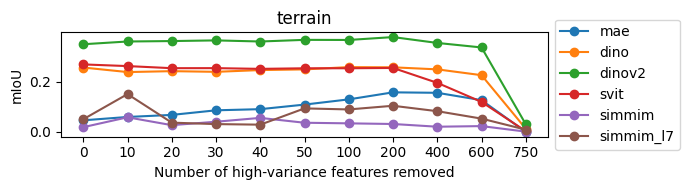

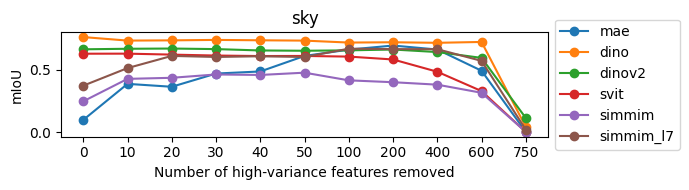

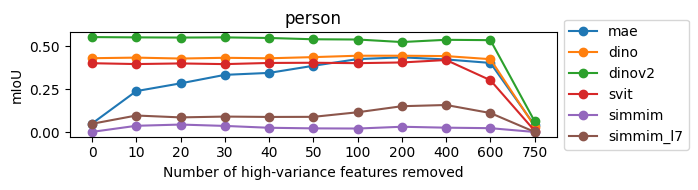

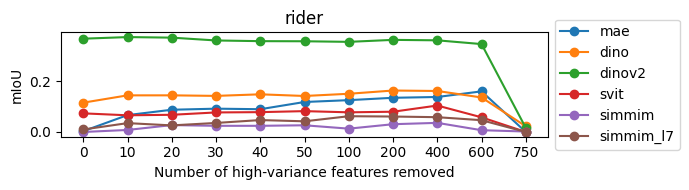

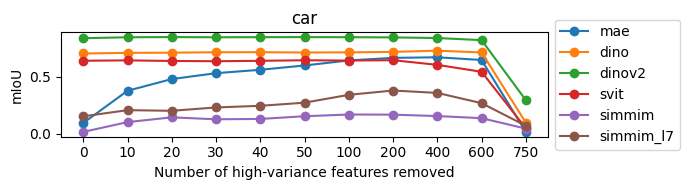

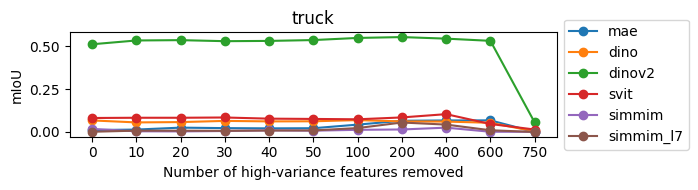

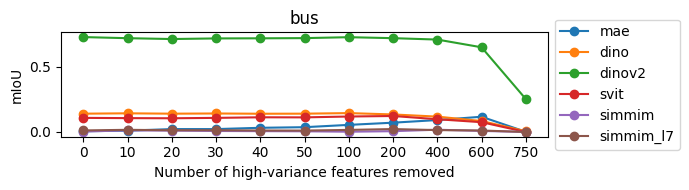

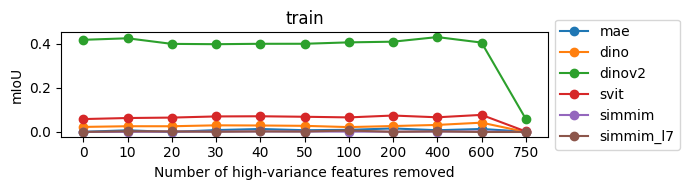

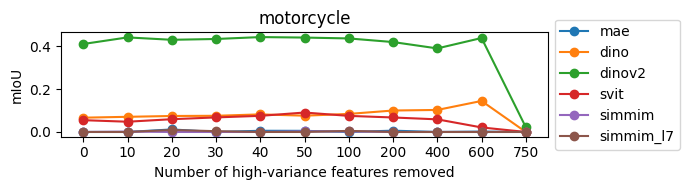

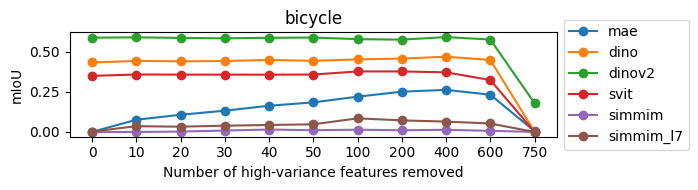

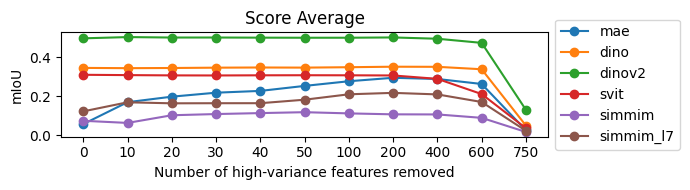

In [22]:
for c in range(20):
    plt.figure(figsize=(7, 2))
    x = range(len(drops))

    plt.plot(x, knn_results['mae'][:,c], marker='o', label='mae');
    plt.plot(x, knn_results['dino'][:,c], marker='o', label='dino');
    plt.plot(x, knn_results['dinov2'][:,c], marker='o', label='dinov2');
    plt.plot(x, knn_results['sup_vit'][:,c], marker='o', label='svit');
    plt.plot(x, knn_results['simmim'][:,c], marker='o', label='simmim');
    plt.plot(x, knn_results['simmim_l7'][:,c], marker='o', label='simmim_l7');
    
    # plt.plot(x, linear_results[model][:,-1], marker='o', label='linear probing');
    plt.ylabel("mIoU")
    plt.xlabel("Number of high-variance features removed")
    # plt.xscale('log')
    # plt.ylim(0, 0.6)
    # plt.xlim(10, 750)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(class_names[c])
    plt.xticks(x, drops);
    plt.tight_layout()